In [193]:
from six import StringIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

import pydot

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

# Binary Classification with Decision Tree
We will use the classic titanic dataset and predict whether individuals survived or not. Let's load the data first. You can learn more about loading `csv` files [here](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html).

In [133]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [134]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Data Cleaning
#### Unnecessary Features
At the beginning, we can rightly discard some features that are completely useless, for example, `PassengerId`, `Name`, `Ticket`, etc. The features that you will discard in this stage will depend on the subject knowledge and common sense.

In [135]:
titanic.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
titanic.sample(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
138,0,3,male,16.0,0,0,9.2167,NaN,S
361,0,2,male,29.0,1,0,27.7208,NaN,C
273,0,1,male,37.0,0,1,29.7000,C118,C


#### Missing Values
This involves handling **missing values**, which can be done by **imputation** (replacing missing values with estimated values) or **deletion** (removing instances or features with missing values). **Outliers**, which are extreme values that deviate from the overall pattern, can be detected and either treated (e.g., by replacing with a threshold value) or removed.

Pandas uses the floating-point value **NaN** (Not a Number) to represent missing data. We call this a sentinel value: when present, it indicates a missing (or null) value. In statistics applications, **NA** data may either be data that does not exist or that exists but was not observed (through problems with data collection, for example). Python's **None** can be considered as `NA`. So, in summary, both **NaN** and **None** works as missing value.  The `isna` method gives us a Boolean Series with True where values are null.

In [136]:
titanic.isna()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False
888,False,False,False,True,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False


We can sum the total number of missing data in each feature.

In [137]:
titanic.isna().sum(axis=0)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Similarly, we can also find the percentage of missing data in each feature.

In [138]:
titanic.isna().sum(axis=0) / titanic.shape[0] * 100

Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

As you can see, almost all the data in the `Cabin` feature is missing. Imputing this feature might result in poor performance. Similarly, removing rows that have missing `Cabin` values will remove almost all the data. So, the only possible solution is to just discard the feature itself. 

In [139]:
titanic.drop(['Cabin'], axis=1, inplace=True)
titanic.tail(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
886,0,2,male,27.0,0,0,13.00,S
887,1,1,female,19.0,0,0,30.00,S
888,0,3,female,NaN,1,2,23.45,S
889,1,1,male,26.0,0,0,30.00,C
890,0,3,male,32.0,0,0,7.75,Q


On the other hand, since there are only two observations that are missing `Embarked`, we can safely remove those two observations using the `dropna` method.

In [140]:
titanic.dropna(inplace=True, subset=['Embarked'])
titanic.isna().sum(axis=0) / titanic.shape[0] * 100

Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         19.910011
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Embarked     0.000000
dtype: float64

Now we can impute the retained features. **However, you must carry out all computations for imputation on the training data first. Therefore, you have to divide your dataset into training and testing set at this stage.**

### Data Partitioning
Splitting the dataset into training, validation, and testing subsets is crucial for evaluating model performance. Common methods include **random** or **stratified** sampling. Let's separate the features and targets first.

In [175]:
X = titanic.iloc[:, 1:]
Y = titanic.iloc[:, 0]

We will perform a stratified partitioning which will make sure that the class distribution of the target variable is equal in both train and test set.

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=25)

print('Original Dataset')
print(Y.value_counts() / Y.shape[0] * 100)
print('Training Dataset')
print(y_train.value_counts() / y_train.shape[0] * 100)
print('Test Dataset')
print(y_test.value_counts() / y_test.shape[0] * 100)

Original Dataset
Survived
0    61.754781
1    38.245219
Name: count, dtype: float64
Training Dataset
Survived
0    61.744023
1    38.255977
Name: count, dtype: float64
Test Dataset
Survived
0    61.797753
1    38.202247
Name: count, dtype: float64


### Imputing Missing Values
One type of imputation algorithm is **univariate**, which imputes values in the $i^{th}$ feature dimension using only non-missing values in that feature dimension (e.g. [`impute.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)). By contrast, **multivariate** imputation algorithms use the entire set of available feature dimensions to estimate the missing values (e.g. [`impute.IterativeImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer)).

In [177]:
simple_imputer_age = SimpleImputer(strategy='median')
simple_imputer_age.fit(X_train[['Age']])
print(simple_imputer_age.statistics_)

[28.]


In [178]:
X_train['SimplyImputedAge'] = simple_imputer_age.transform(X_train[['Age']])
X_test['SimplyImputedAge'] = simple_imputer_age.transform(X_test[['Age']])

In [179]:
X_train.isna().sum(axis=0) / X_train.shape[0] * 100

Pclass               0.000000
Sex                  0.000000
Age                 20.675105
SibSp                0.000000
Parch                0.000000
Fare                 0.000000
Embarked             0.000000
SimplyImputedAge     0.000000
dtype: float64

In [180]:
X_train.drop(['Age'], axis=1, inplace=True)
X_test.drop(['Age'], axis=1, inplace=True)

### Feature Encoding
Categorical features often need to be encoded numerically for machine learning algorithms to process them. **One-hot encoding** is commonly used, where each category is represented by a binary indicator variable. **Label encoding** assigns a unique integer to each category, but it may introduce an incorrect ordinal relationship.

In [181]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [182]:
X_train.head()

,Pclass,SibSp,Parch,Fare,SimplyImputedAge,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
767,3,0,0,7.7500,30.5,True,False,False,True,False
280,3,0,0,7.7500,65.0,False,True,False,True,False
667,3,0,0,7.7750,28.0,False,True,False,False,True
493,1,0,0,49.5042,71.0,False,True,True,False,False
846,3,8,2,69.5500,28.0,False,True,False,False,True


### Feature Transformation
Nonlinear transformations can be applied to features to make the relationship with the target variable more linear or to satisfy certain assumptions of the model. Examples include **logarithmic**, **exponential**, and **square root** transformations.

Now we will explore the age of the passengers and fare of the tickets. One common way to visulize numeric variables is `histogram`. You can learn more about `histplot` [here](https://seaborn.pydata.org/generated/seaborn.histplot.html).

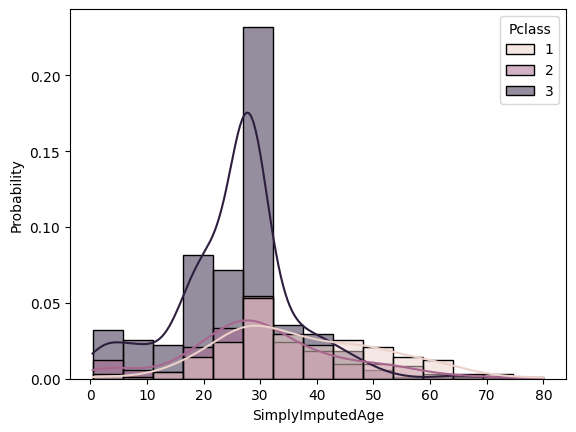

In [183]:
sns.histplot(data=X_train, x='SimplyImputedAge', bins=15, hue='Pclass', kde=True, stat='probability')
plt.show()

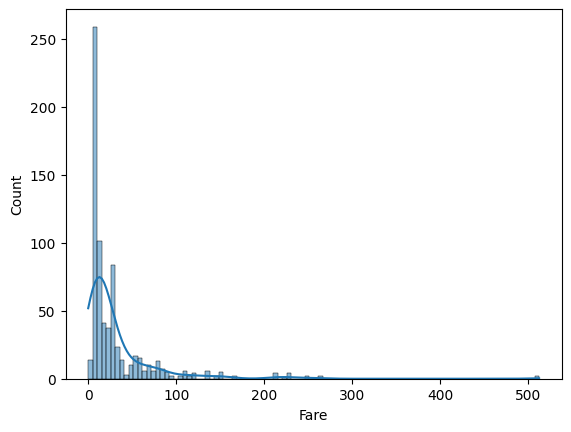

In [184]:
sns.histplot(data=X_train, x='Fare', bins=100, kde=True, stat='count')
plt.show()

As you can see, the variable is highly skewed. If a feature has a highly skewed distribution, where the majority of values are concentrated at one end and there are a few extreme values, applying a logarithmic transformation can help normalize the distribution. This transformation compresses the range of values and reduces the impact of extreme values, making the distribution more symmetric.

In [185]:
X_train['Fare'] = np.log(X_train['Fare'] + 1)
X_test['Fare'] = np.log(X_test['Fare'] + 1)

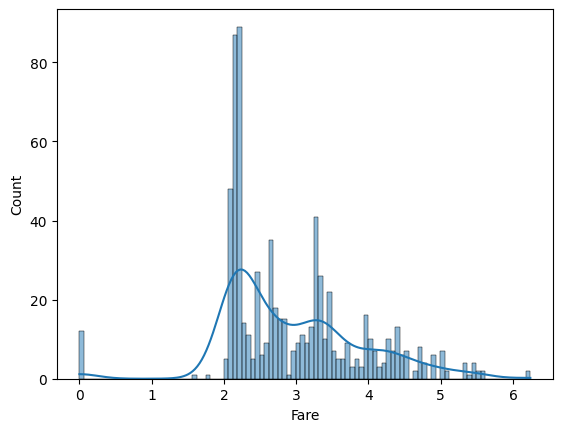

In [186]:
sns.histplot(data=X_train, x='Fare', bins=100, kde=True, stat='count')
plt.show()

### Handling Imbalanced Data
When dealing with imbalanced datasets where one class is underrepresented, techniques such as oversampling the minority class (e.g., SMOTE) or undersampling the majority class can be used to balance the classes. If your features are imbalanced, you can try different **ensemble** methods instead. You can also remove the feature and compare with a model without this feature to see how the feature impact the results.

First we will see the class distribution of `Sex` with respect to passenger class. You can learn more about `countplot` [here](https://seaborn.pydata.org/generated/seaborn.countplot.html).

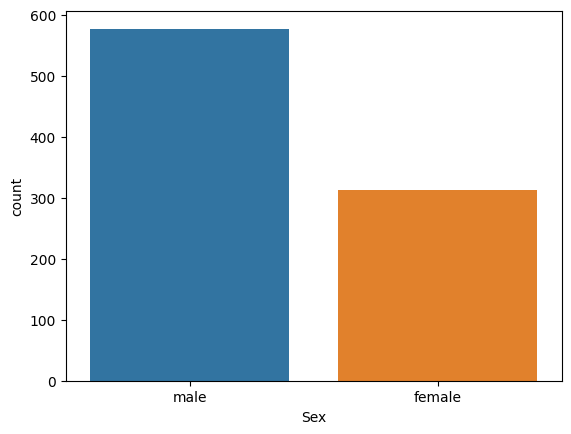

In [188]:
sns.countplot(data=X, x='Sex')
plt.show()

Next, we will explore the class distribution of our dependent variable.

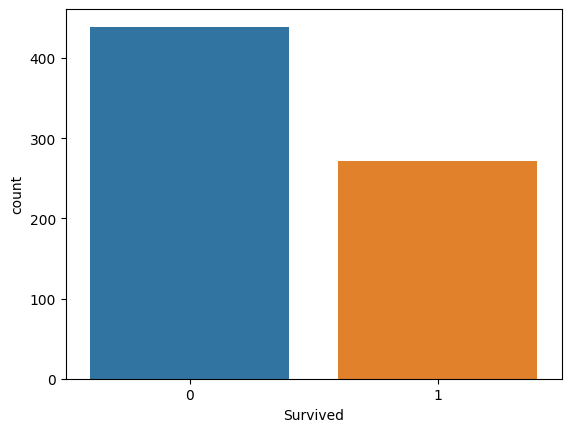

In [189]:
sns.countplot(x=y_train)
plt.show()

As you can see, passengers who survived are little under-represented in the dataset. We can leverage various oversampling techniques to level representations of both classes. A good library for oversampling or undersampling is `imblearn`. You can learn about different techniques of over and undersampling in their [documentation](https://imbalanced-learn.org/stable/user_guide.html). For this case, we will be using the `SMOTE` algorithm.

In [190]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

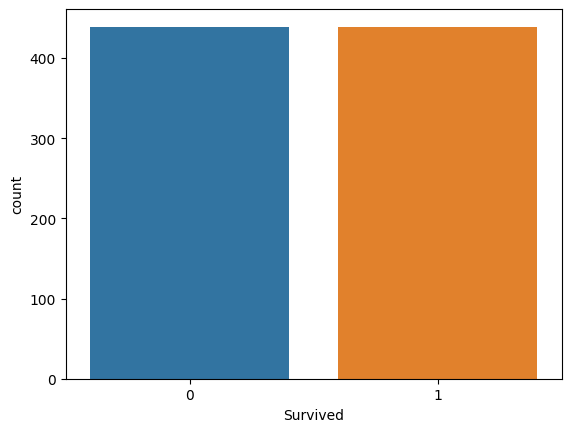

In [191]:
sns.countplot(x=y_train_resampled)
plt.show()

### Hyperparameter Tuning
Hyperparameters are parameters that are not learned from the data but set before the learning process begins. Hyperparameter tuning refers to the process of finding the optimal values for the hyperparameters of a machine learning algorithm. They control aspects of the model's behavior and performance, such as the learning rate, regularization strength, etc.

Hyperparameter tuning is important because the choice of hyperparameters can significantly impact the performance of the model. Setting them to suboptimal values may result in underfitting or overfitting, leading to poor generalization and decreased performance on unseen data. By tuning the hyperparameters, we aim to find the best configuration that maximizes the model's performance on the validation or test set. The process of hyperparameter tuning typically involves the following steps:

- **Define the Hyperparameter Search Space:** Determine the range or possible values for each hyperparameter that you want to tune. This can be a continuous range, a set of discrete values, or a predefined set of options.
- **Choose an Optimization Strategy:** Select a strategy or algorithm for searching the hyperparameter space. Common methods include grid search, random search, Bayesian optimization, or more advanced techniques like genetic algorithms or gradient-based optimization.
- **Evaluation Metric:** Choose an appropriate evaluation metric to assess the performance of the model during hyperparameter tuning. This could be accuracy, precision, recall, F1-score, or any other metric relevant to your specific problem.
- **Search and Evaluation:** Perform a systematic search of the hyperparameter space by training and evaluating the model with different combinations of hyperparameters. Typically, this involves training multiple models and evaluating their performance using cross-validation or a held-out validation set.
- **Select the Best Hyperparameters:** Identify the best set of hyperparameters that maximize the model's performance according to the chosen evaluation metric. This is usually based on the results obtained during the search process.
- **Validate the Model:** After selecting the best hyperparameters, it is important to evaluate the model's performance on an independent test set to ensure that the hyperparameter tuning process did not lead to overfitting the validation set.

Hyperparameter tuning can be a computationally intensive process as it requires training and evaluating multiple models. However, finding the optimal hyperparameters is crucial for achieving the best performance and generalization of the model. It often involves a trade-off between exploration (searching a wide range of hyperparameters) and exploitation (narrowing down to promising regions). Automated hyperparameter tuning libraries and frameworks are available to streamline this process and assist in finding the optimal hyperparameter configuration efficiently.

#### Defining Search Space

`Scikit-Learn` uses the Classification and Regression Tree (CART) algorithm to train Decision
Trees. Some of the hyper-parameters that you can tune are as follows:

- **Maximum depth:** This hyperparameter limits the maximum depth of the decision tree. A smaller maximum depth can help prevent overfitting, while a larger maximum depth may improve the model's ability to capture complex relationships in the data.
- **Minimum samples per split:** This hyperparameter sets the minimum number of samples required to split a node. A higher value can lead to simpler trees and can help prevent overfitting, while a lower value can allow the algorithm to capture more detailed relationships in the data.
- **Minimum samples per leaf:** This hyperparameter sets the minimum number of samples required to form a leaf node. A higher value can lead to simpler trees and can help prevent overfitting, while a lower value can allow the algorithm to capture more detailed relationships in the data.
- **Maximum number of leaf nodes:** This hyperparameter limits the maximum number of leaf nodes in the decision tree. A smaller value can lead to simpler trees and can help prevent overfitting, while a larger value can allow the algorithm to capture more detailed relationships in the data.
- **Splitting criteria:** This hyperparameter specifies the criteria used to determine how to split a node. The two most common splitting criteria are the Gini impurity and the entropy. Gini impurity measures the probability of misclassification and tries to minimize it, while entropy measures the degree of disorder in the data and tries to maximize the information gain.

In [192]:
params = {
    "criterion": ("gini", "entropy", "log_loss"), 
    "splitter": ("best", "random"), 
    "max_depth": (list(range(1, 20))), 
    "min_samples_split": list(range(2, 20)), 
    "min_samples_leaf": list(range(1, 20)), 
}

#### Setting Optimization Strategy & Evaluation Metric
While grid search looks at every possible combination of hyperparameters to find the best model, random search only selects and tests a random combination of hyperparameters. This technique randomly samples from a grid of hyperparameters instead of conducting an exhaustive search. You can find other search strategy offered by `sklearn` [here](https://scikit-learn.org/stable/modules/grid_search.html).

In [200]:
tree_clf = DecisionTreeClassifier(random_state=25)
tree_cv = RandomizedSearchCV(
    tree_clf, 
    params, 
    scoring="f1",
    n_jobs=-1, 
    verbose=2, 
    cv=5,
    n_iter=500
)

#### Search & Evaluation

In [201]:
tree_cv.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=25),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ('gini', 'entropy',
                                                      'log_loss'),
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19],
                                        'splitter': ('best', 'random')},
                   scoring='f1', verbose=2)

#### Selecting Best Hyperparameters

In [202]:
best_params = tree_cv.best_params_
for param in best_params.keys():
    print(param, ':', best_params[param])

splitter : best
min_samples_split : 3
min_samples_leaf : 3
max_depth : 6
criterion : entropy


#### Validating Best Model

- **Precision:** Precision is a performance metric that measures the proportion of correctly predicted positive instances out of the total instances predicted as positive by a classification model. It focuses on the accuracy of the positive predictions made by the model. Precision is particularly useful in scenarios where the cost of false positives is high or when we want to ensure that the positive predictions made by the model are highly accurate. It indicates how precise or reliable the model is in identifying positive instances. A high precision value means that the model has a low rate of false positives, implying that when it predicts a positive instance, it is more likely to be correct. On the other hand, a low precision value suggests that the model has a higher tendency to produce false positive predictions.
- **Recall/Sensitivity/True Positive Rate:** Is a performance metric that measures the ability of a classification model to identify all relevant instances of a particular class. It is particularly useful in scenarios where the identification of positive instances is crucial and missing them could have significant consequences. A high recall value indicates that the model is effective at capturing the positive instances and minimizing false negatives. It means that the model has a low tendency to miss positive instances. On the other hand, a low recall value suggests that the model is not performing well in identifying positive instances and is prone to false negatives.
- **f1 Score:** The F1 score is a commonly used metric in machine learning that combines the precision and recall of a classification model into a single value. It is particularly useful when dealing with imbalanced datasets where the distribution of classes is uneven. The harmonic mean is used to ensure that the F1 score gives more weight to lower values. If either precision or recall is low, the F1 score will be lower compared to just taking their arithmetic mean. This is useful for situations where both precision and recall are important, and striking a balance between them is desired. The F1 score ranges from 0 to 1, with 1 indicating perfect precision and recall, and 0 indicating poor performance. A higher F1 score implies better overall performance of the classifier in terms of both precision and recall.
- **Support:** The support of a classification model refers to the number of samples in the training data that are assigned to each class. In other words, it represents the frequency or count of instances belonging to a particular class in the training set.
- **Macro Vs. Weighted Average:** In machine learning, when dealing with multi-class classification tasks, it is common to evaluate the performance of the model using metrics such as precision, recall, and F1-score. Two popular methods for calculating these metrics are macro-average and weighted average. Here's the difference between the two:
    - **Macro-average:** In macro-average, the metric is calculated independently for each class, and then the average is taken across all classes. Each class is given equal importance in the calculation, regardless of its support (the number of samples in that class). This means that the performance of each class contributes equally to the final macro-average metric. It is suitable when you want to evaluate the overall performance of the model without considering class imbalances.
    - **Weighted average:** In weighted average, the metric is calculated by considering the support of each class. The weighted average takes into account the number of samples in each class, giving more weight to classes with higher support. The weighted average metric reflects the overall performance of the model while considering the class distribution. It is suitable when there are class imbalances, and you want to emphasize the performance of the majority classes.

In [203]:
best_model = tree_cv.best_estimator_

In [204]:
train_preds = best_model.predict(X_train_resampled)
test_preds = best_model.predict(X_test)

train_clf_report = pd.DataFrame(classification_report(y_train_resampled, train_preds, output_dict=True))
test_clf_report = pd.DataFrame(classification_report(y_test, test_preds, output_dict=True))

TRAINING RESULT

ACCURACY SCORE: 86.79%
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.851852    0.885442  0.867882    0.868647      0.868647
recall       0.890661    0.845103  0.867882    0.867882      0.867882
f1-score     0.870824    0.864802  0.867882    0.867813      0.867813
support    439.000000  439.000000  0.867882  878.000000    878.000000
CONFUSION MATRIX:


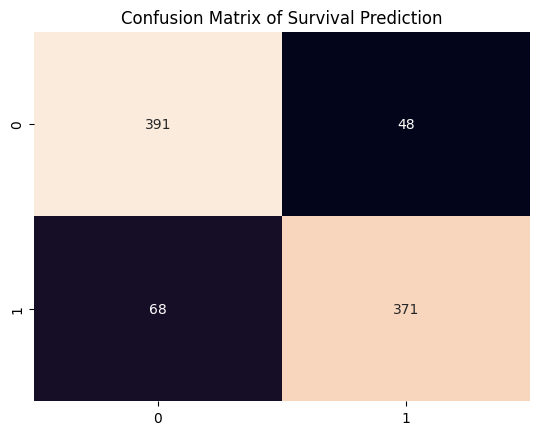

In [205]:
print("TRAINING RESULT\n")
print(f"ACCURACY SCORE: {accuracy_score(y_train_resampled, train_preds) * 100:.2f}%")
print(f"CLASSIFICATION REPORT:\n{train_clf_report}")
print(f"CONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_train_resampled, train_preds),
            annot=True, cbar=False, fmt='d'
        )
plt.title('Confusion Matrix of Survival Prediction')
plt.show()

TEST RESULT

ACCURACY SCORE: 79.21%
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.834862   0.724638  0.792135    0.779750      0.792754
recall       0.827273   0.735294  0.792135    0.781283      0.792135
f1-score     0.831050   0.729927  0.792135    0.780489      0.792419
support    110.000000  68.000000  0.792135  178.000000    178.000000
CONFUSION MATRIX:


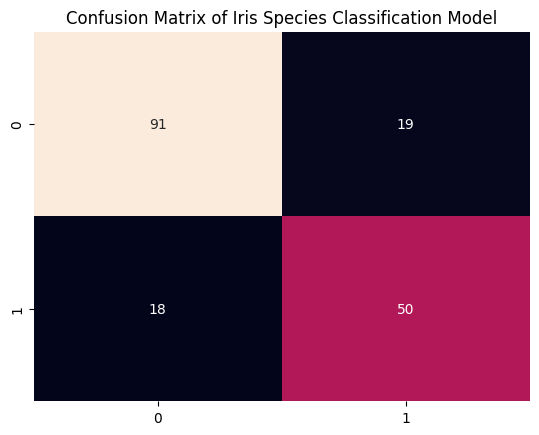

In [206]:
print("TEST RESULT\n")
print(f"ACCURACY SCORE: {accuracy_score(y_test, test_preds) * 100:.2f}%")
print(f"CLASSIFICATION REPORT:\n{test_clf_report}")
print(f"CONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_test, test_preds),
            annot=True, cbar=False, fmt="d"
        )
plt.title('Confusion Matrix of Iris Species Classification Model')
plt.show()

#### ROC Curve
The ROC (Receiver Operating Characteristic) curve is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is commonly used in machine learning and statistics to evaluate the performance of a classification model.

The ROC curve is created by plotting the **true positive rate (sensitivity)** on the y-axis against the **false positive rate (1-specificity)** on the x-axis. The true positive rate is the ratio of correctly classified positive instances to the total number of actual positive instances. The false positive rate is the ratio of incorrectly classified negative instances to the total number of actual negative instances.

To generate an ROC curve, the classification model's predictions are sorted based on their confidence scores or probability estimates. The discrimination threshold is then gradually adjusted from the highest to the lowest prediction scores, and at each threshold, the true positive rate and false positive rate are calculated. The points obtained at each threshold are plotted on the graph, and the resulting curve summarizes the model's performance across various classification thresholds.

A good classifier is expected to have an ROC curve that is closer to the top-left corner of the plot, indicating higher true positive rates and lower false positive rates across different thresholds. The area under the ROC curve (AUC) is often used as a metric to quantify the overall performance of the classifier. A perfect classifier would have an AUC of 1, while a random or ineffective classifier would have an AUC close to 0.5.

The ROC curve provides a useful visual tool for comparing and selecting models, as well as understanding the trade-off between sensitivity and specificity at different threshold settings. It allows practitioners to choose a threshold that aligns with their specific needs, based on the relative importance of true positives and false positives in a given application.

In [207]:
y_test_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
auc = roc_auc_score(y_test, y_test_pred_prob)

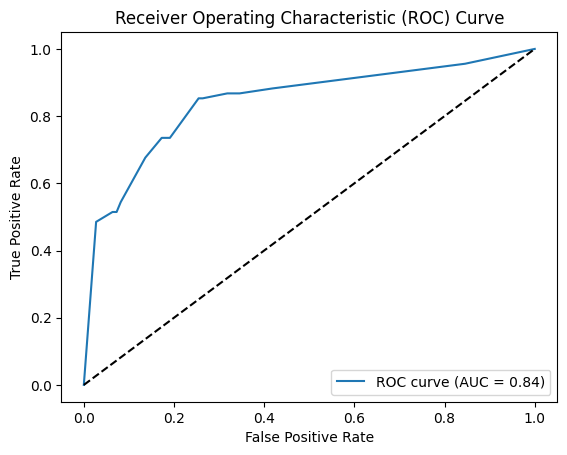

In [208]:
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Multi-class Classification with Decision Tree
In this example, we will be classifying the IRIS dataset using `DecisionTreeClassifier`.

In [209]:
iris = pd.read_csv('./data/iris.csv')
iris.sample(5)

,sepal.length,sepal.width,petal.length,petal.width,variety
134,6.1,2.6,5.6,1.4,Virginica
102,7.1,3.0,5.9,2.1,Virginica
14,5.8,4.0,1.2,0.2,Setosa
81,5.5,2.4,3.7,1.0,Versicolor
32,5.2,4.1,1.5,0.1,Setosa


In [210]:
X = iris.iloc[:, :4]
y = iris.iloc[:, 4]

print(X.shape)
print(y.shape)

(150, 4)
(150,)


Decision Trees are advantageous because to their low overhead in terms of the amount of time needed to get the data ready for analysis. They don't need any scaling or centering of the features at all. However, you must split the data into train and test set.

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True, random_state=25)

We will develop a very simple decision tree algorithm using all the deafult parameters.

In [212]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

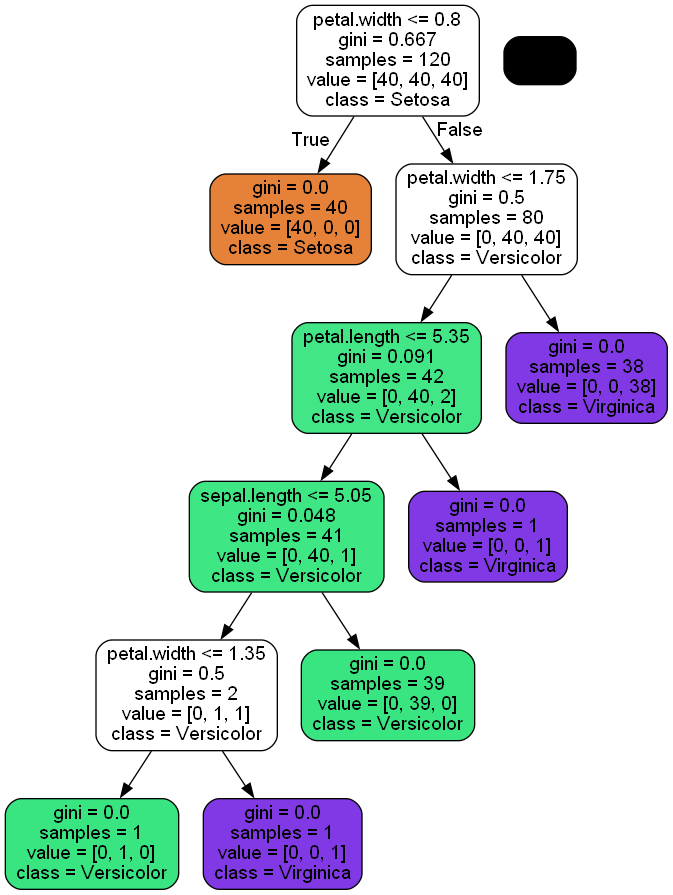

In [213]:
dot_data = StringIO()
export_graphviz(
        tree_clf,
        out_file=dot_data,
        feature_names=iris.columns[:-1],
        class_names=iris['variety'].unique(),
        rounded=True,
        filled=True
    )
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

A Decision Tree can also estimate the probability that an instance belongs to a particular
class `k`. First it traverses the tree to find the leaf node for this instance, and then it returns the
ratio of training instances of class k in this node.

In [ ]:
train_preds = tree_clf.predict(X_train)
test_preds = tree_clf.predict(X_test)

train_clf_report = pd.DataFrame(classification_report(y_train, train_preds, output_dict=True))
test_clf_report = pd.DataFrame(classification_report(y_test, test_preds, output_dict=True))

In [ ]:
print("TRAINING RESULT\n")
print(f"ACCURACY SCORE: {accuracy_score(y_train, train_preds) * 100:.2f}%")
print(f"CLASSIFICATION REPORT:\n{train_clf_report}")
print(f"CONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_train, train_preds),
            annot=True, cbar=False,
            xticklabels=iris['variety'].unique(),
            yticklabels=iris['variety'].unique(),
        )
plt.title('Confusion Matrix of Iris Species Classification Model')
plt.show()

In [ ]:
print("TEST RESULT\n")
print(f"ACCURACY SCORE: {accuracy_score(y_test, test_preds) * 100:.2f}%")
print(f"CLASSIFICATION REPORT:\n{test_clf_report}")
print(f"CONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_test, test_preds),
            annot=True, cbar=False,
            xticklabels=iris['variety'].unique(),
            yticklabels=iris['variety'].unique(),
        )
plt.title('Confusion Matrix of Iris Species Classification Model')
plt.show()

### Hyper-Parameter Tuning

In [ ]:
params = {
    "criterion": ("gini", "entropy", "log_loss"), 
    "splitter": ("best", "random"), 
    "max_depth": (list(range(1, 20))), 
    "min_samples_split": list(range(2, 20)), 
    "min_samples_leaf": list(range(1, 20)), 
}

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=25)
tree_cv = GridSearchCV(
    tree_clf, 
    params, 
    scoring="accuracy", 
    n_jobs=-1, 
    verbose=1, 
    cv=5
)
tree_cv.fit(X_train, y_train)

In [ ]:
best_params = tree_cv.best_params_
for param in best_params.keys():
    print(param, ':', best_params[param])

In [ ]:
tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)

### Model Evaluation

In [ ]:
train_preds = tree_clf.predict(X_train)
test_preds = tree_clf.predict(X_test)

train_clf_report = pd.DataFrame(classification_report(y_train, train_preds, output_dict=True))
test_clf_report = pd.DataFrame(classification_report(y_test, test_preds, output_dict=True))

In [ ]:
print("TRAINING RESULT\n")
print(f"ACCURACY SCORE: {accuracy_score(y_train, train_preds) * 100:.2f}%")
print(f"CLASSIFICATION REPORT:\n{train_clf_report}")
print(f"CONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_train, train_preds),
            annot=True, cbar=False,
            xticklabels=iris['variety'].unique(),
            yticklabels=iris['variety'].unique(),
        )
plt.title('Confusion Matrix of Iris Species Classification Model')
plt.show()

In [ ]:
print("TEST RESULT\n")
print(f"ACCURACY SCORE: {accuracy_score(y_test, test_preds) * 100:.2f}%")
print(f"CLASSIFICATION REPORT:\n{test_clf_report}")
print(f"CONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_test, test_preds),
            annot=True, cbar=False,
            xticklabels=iris['variety'].unique(),
            yticklabels=iris['variety'].unique(),
        )
plt.title('Confusion Matrix of Iris Species Classification Model')
plt.show()